## **Importing Modules**

In [1]:
#importing required modules

import gdown
import zipfile
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

import torchvision.models as models
import torch
import torch.nn as nn
from torchsummary import summary
from torchvision import datasets, transforms as T
from torch.utils.data import Dataset, DataLoader

import os
import torch.optim as optim
from PIL import ImageFile

from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, accuracy_score, roc_curve


## **Data Preprocessing**

In [2]:
#importing data

#Dataset address
url = 'https://drive.google.com/uc?export=download&id=1B75cOYH7VCaiqdeQYvMuUuy_Mn_5tPMY'
output = 'data.zip'
gdown.download(url, output, quiet=False)

#giving zip file name
data_dir='./data.zip'

#extractng data from zip file
with zipfile.ZipFile(data_dir, 'r') as zf:
    zf.extractall('./data')
    print('Done downloading and extraction')

#removing zip file after extraction
!rm './data.zip' 

#invstigating number of files
orange_files = np.array(glob("/content/data/*/*/*"))
print('There are %d total chest xray images.' % len(orange_files))

#checking the availability of a GPU
use_cuda = torch.cuda.is_available()

Downloading...
From: https://drive.google.com/uc?export=download&id=1B75cOYH7VCaiqdeQYvMuUuy_Mn_5tPMY
To: /content/data.zip
100%|██████████| 46.1M/46.1M [00:00<00:00, 100MB/s]


Done downloading and extraction
There are 4626 total chest xray images.


In [3]:
transform = T.Compose([T.ToTensor(),])
orange_file='./data/'

train_path=os.path.join(orange_file,'train')
dataset = datasets.ImageFolder(train_path,transform=transform)
dataloader = DataLoader(dataset, batch_size=1, num_workers=1, shuffle=False)

mean = torch.zeros(3)
std = torch.zeros(3)

for i, data in enumerate(dataloader):
    if (i % 10000 == 0): print(i)
    data = data[0].squeeze(0)
    if (i == 0): size = data.size(1) * data.size(2)
    mean += data.sum((1, 2)) / size

mean /= len(dataloader)
print(mean)
mean = mean.unsqueeze(1).unsqueeze(2)

for i, data in enumerate(dataloader):
    if (i % 10000 == 0): print(i)
    data = data[0].squeeze(0)
    std += ((data - mean) ** 2).sum((1, 2)) / size

std /= len(dataloader)
std = std.sqrt()
print(std)

0
tensor([0.5219, 0.5220, 0.5223])
0
tensor([0.2476, 0.2476, 0.2477])


In [4]:
#declaring batch size
batch_size = 32

#applying required transformations on the dataset
img_transforms = {
    'train':
    T.Compose([
        T.Resize(size=(224,224)), 
        T.ToTensor(),
        T.Normalize([0.5219, 0.5220, 0.5223], [0.2476, 0.2476, 0.2477]), 
    ]),
    

    'valid':
    T.Compose([
        T.Resize(size=(224,224)),
        T.ToTensor(),
        T.Normalize([0.5219, 0.5220, 0.5223], [0.2476, 0.2476, 0.2477])
    ]),


    'test':
    T.Compose([
        T.Resize(size=(224,224)),
        T.ToTensor(),
        T.Normalize([0.5219, 0.5220, 0.5223], [0.2476, 0.2476, 0.2477])
    ]),
}


#  creating Location of data: train, validation, test
orange_file='./data/'

train_path=os.path.join(orange_file,'train')
valid_path=os.path.join(orange_file,'test')
test_path=os.path.join(orange_file,'valid')


# creating Datasets to each of  folder created in prev
train_file=datasets.ImageFolder(train_path,transform=img_transforms['train'])
valid_file=datasets.ImageFolder(valid_path,transform=img_transforms['valid'])
test_file=datasets.ImageFolder(test_path,transform=img_transforms['test'])


#Creating loaders for the dataset
loaders_transfer={
    'train':torch.utils.data.DataLoader(train_file,batch_size,shuffle=True),
    'valid':torch.utils.data.DataLoader(valid_file,batch_size,shuffle=True),
    'test': torch.utils.data.DataLoader(test_file,batch_size,shuffle=True)
}

## **Model Building**

In [5]:
# Importing the pretrained model
model_transfer = models.resnet50(pretrained=True)

# Freeze weights
for param in model_transfer.parameters():
    param.requires_grad = False

n_inputs = model_transfer.fc.in_features

#Replacing the top dense layers with self defined trainable layers
model_transfer.fc = nn.Sequential(
    nn.Linear(n_inputs, 1024),
    nn.LeakyReLU(inplace = True),

    nn.Linear(1024,512),
    nn.LeakyReLU(inplace=True),
            
    nn.Linear(512,256),
    nn.LeakyReLU(inplace=True),

    nn.Linear(256,64),
    nn.LeakyReLU(inplace=True),

    nn.Linear(64,16),
    nn.LeakyReLU(inplace=True),

    nn.Linear(16,2),
    nn.Sigmoid()
)

#transferring the model to GPU
if use_cuda:
    model_transfer = model_transfer.cuda()

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [6]:
summary(model_transfer, (3, 224,224))

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [7]:
# selecting loss function
criterion_transfer = nn.CrossEntropyLoss()

#using Adam optimizer
optimizer_transfer = optim.Adam(model_transfer.fc.parameters(), lr=0.0005)

## **Training and Validating the Model**



In [8]:

ImageFile.LOAD_TRUNCATED_IMAGES = True

# Creating the function for training
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    trainingloss = []
    validationloss = []

    for epoch in range(1, n_epochs+1):
        # initialize the variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        correct1 = 0.
        total1 = 0.
        correct2 = 0.
        total2 = 0.

        ###################
        # training the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
          
            optimizer.zero_grad()
            output = model(data)

            loss = criterion(output, target)
            
            loss.backward()
            optimizer.step()
           
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            pred = output.data.max(1, keepdim=True)[1]
            # compare predictions
            correct1 += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
            total1 += data.size(0)

       
        ######################    
        # validating the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            
            output = model(data)
            loss = criterion(output, target)
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))
            pred = output.data.max(1, keepdim=True)[1]
            # compare predictions
            correct2 += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
            total2 += data.size(0)

      

        train_loss = train_loss/len(train_file)
        valid_loss = valid_loss/len(valid_file)

        trainingloss.append(train_loss)
        validationloss.append(valid_loss)
        acc1 = 100. * correct1 / total1
        acc2 =  100. * correct2 / total2
        # printing training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tTraining Accuracy: {:.4f} \tValidation Loss: {:.6f} \tValidation Accuracy: {:.4f}'.format(
            epoch,
            train_loss,
            acc1,
            valid_loss,
            acc2
            ))
        
        ## saving the model if validation loss has decreased
        if valid_loss < valid_loss_min:
            torch.save(model.state_dict(), save_path)
            
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            
            valid_loss_min = valid_loss
            
    # return trained model
    return model, trainingloss, validationloss

In [9]:
# training the model

n_epochs=50

model_transfer, train_loss, valid_loss = train(n_epochs, loaders_transfer, model_transfer, optimizer_transfer, criterion_transfer, use_cuda, 'model_transfer.pt')

Epoch: 1 	Training Loss: 0.000132 	Training Accuracy: 83.0902 	Validation Loss: 0.000976 	Validation Accuracy: 85.7143
Validation loss decreased (inf --> 0.000976).  Saving model ...
Epoch: 2 	Training Loss: 0.000116 	Training Accuracy: 88.1686 	Validation Loss: 0.000899 	Validation Accuracy: 88.7446
Validation loss decreased (0.000976 --> 0.000899).  Saving model ...
Epoch: 3 	Training Loss: 0.000112 	Training Accuracy: 89.6813 	Validation Loss: 0.000838 	Validation Accuracy: 92.6407
Validation loss decreased (0.000899 --> 0.000838).  Saving model ...
Epoch: 4 	Training Loss: 0.000111 	Training Accuracy: 89.6272 	Validation Loss: 0.000826 	Validation Accuracy: 93.0736
Validation loss decreased (0.000838 --> 0.000826).  Saving model ...
Epoch: 5 	Training Loss: 0.000105 	Training Accuracy: 92.4635 	Validation Loss: 0.001018 	Validation Accuracy: 83.9827
Epoch: 6 	Training Loss: 0.000107 	Training Accuracy: 91.3830 	Validation Loss: 0.000819 	Validation Accuracy: 93.0736
Validation loss

In [10]:
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

<All keys matched successfully>

##  **Testing the Model**



In [11]:
# Defining the test function

def test(loaders, model, criterion, use_cuda):

    # monitoring test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.
    preds = []
    targets = []

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # moving to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # updating average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # converting the output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        preds.append(pred)
        targets.append(target)
        # compare predictions
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    # print('Test Loss: {:.7f}\n'.format(test_loss))

    # print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
    #     100. * correct / total, correct, total))
    
    return preds, targets

# calling test function
preds, targets = test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

## **Visulizing the results**

In [12]:
#converting the tensor object to a list for metric functions

preds2, targets2 = [],[]

for i in preds:
  for j in range(len(i)):
    preds2.append(i.cpu().numpy()[j])
for i in targets:
  for j in range(len(i)):
    targets2.append(i.cpu().numpy()[j])

Confusion Matrix:
 [[221   2]
 [ 10 229]]


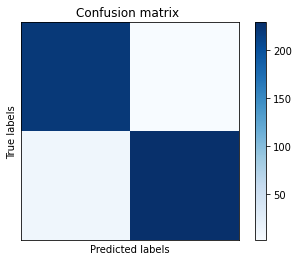

In [13]:
#plotting the confusion matrix for testing data

cm = confusion_matrix(preds2, targets2)
print('Confusion Matrix:\n', cm)
plt.imshow(cm, cmap = plt.cm.Blues)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.xticks([], [])
plt.yticks([], [])
plt.title('Confusion matrix ')
plt.colorbar()
plt.show()

AUC score:  0.974025974025974
Accuracy:  0.974025974025974
F1 score:  0.9744680851063829
Precision score:  0.9581589958158996
Recall score:  0.9913419913419913


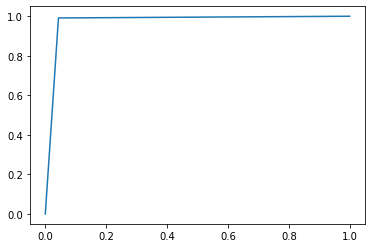

In [14]:
#Computing the 5 evaluation metrics and printing

acc = accuracy_score(targets2, preds2)

fpr, tpr, _ = roc_curve(targets2, preds2)

area = roc_auc_score(targets2, preds2)
print("AUC score: ", area)

print("Accuracy: ", acc)

f1 = f1_score(targets2, preds2)
print("F1 score: ", f1)

pre = precision_score(targets2, preds2)
print("Precision score: ", pre)

recall = recall_score(targets2, preds2)
print("Recall score: ", recall)

plt.plot(fpr, tpr)

Text(0, 0.5, 'loss')

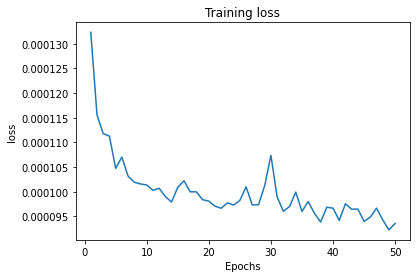

In [15]:
#Plotting the training loss

plt.plot(range(1,51),train_loss)
plt.title("Training loss")
plt.xlabel('Epochs')
plt.ylabel("loss")

Text(0, 0.5, 'loss')

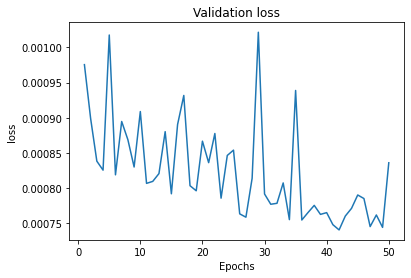

In [16]:
#Plotting the validation loss

plt.plot(range(1,1+n_epochs),valid_loss)
plt.title("Validation loss")
plt.xlabel('Epochs')
plt.ylabel("loss")